In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

## Itroduction

This Project will explore 2 different deep learning architectures for detecting histopathologic cancer cells in images. We will be utilizing computer vision neural networks, the first will be a basic Convolutional Neural Network and the second one will be a more complicated Residual Network. The training data contains 220,000 labeled images, and each image is 96x96 pixels.

First we will load the dataset and do some basic EDA.

In [3]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [5]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

In [6]:
train_imgs = os.listdir(train_dir)

In [7]:
train_imgs[0]

'd43c081bafa286f9c1f7e921883f26ceafebc912.tif'

## Basic EDA

Here we very quickly explore the data we are given by viewing an example image and checking how many positive and negative examples we have. We will clean the data a little bit later on by normalizing images pixel values.

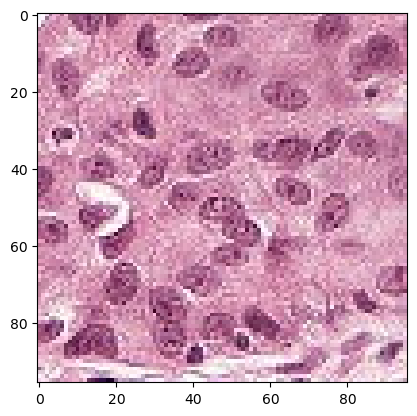

In [8]:
im = Image.open(train_dir + '/' + train_imgs[0])
plt.imshow(im)

In [9]:
positive = 0
negative = 0
for i in range(len(labels_df['label'])):
    if labels_df['label'].iloc[i] == 1:
        positive += 1
    else:
        negative += 1

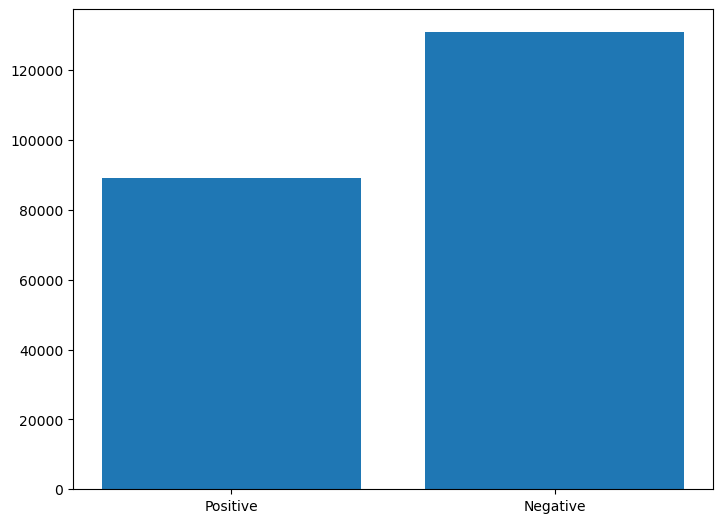

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l = ['Positive', 'Negative']
v = [positive, negative]
ax.bar(l,v)
plt.show()

In [11]:
im.size

(96, 96)

In [12]:
labels_dict = {}
for i in range(len(labels_df)):
    labels_dict[labels_df.iloc[i, 0]] = labels_df.iloc[i, 1]

In [13]:
all_y = []
for img in train_imgs:
    all_y.append(labels_dict[img.split('.')[0]])

In [14]:
assert len(all_y) == len(train_imgs)

In [15]:
split = int(len(train_imgs) * 0.95)

train_X = train_imgs[:split]
val_X = train_imgs[split:]

train_y = all_y[:split]
val_y = all_y[split:]

print(len(train_X))

209023


## Model Architecture

The first model is a very simple and small CNN with 3 convolution layers and 3 linear layers. This first model I do not use in my submission as it didn't perform well. The second model I am using is a Residual Network with 4 residual blocks and over a dozen convolution layers. In total the model has 1.5 million trainable parameters, which performed better than the first model.

In [16]:
CIn = 3
init_f = 8

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Conv size ((W−K+2P)/S)+1
        self.conv1 = nn.Conv2d(CIn, init_f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(init_f, init_f*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(init_f*2, init_f*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.transpose(1, 3)
        x = F.relu(self.conv1(x)) # IN: (96,96,3) OUT: (96,96,8)
        x = self.pool(x)          # OUT: (48,48,8)
        x = F.relu(self.conv2(x)) # OUT: (48,48,16)
        x = self.pool(x)          # OUT: (24,24,16)
        x = F.relu(self.conv3(x)) # OUT: (24,24,32)
        x = self.pool(x)          # OUT: (12,12,32)
        x = x.view(-1, 32 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [17]:
class CustomDataset(Dataset):
    def __init__(self, examples, labels):
        self.examples = examples
        self.labels = labels
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        example = torch.Tensor(np.asarray(Image.open(train_dir + '/' + self.examples[idx])))
        label = self.labels[idx]
        
        return example, label

In [18]:
# train_x = []
# for img in train_imgs:
#     train_x.append(np.asarray(Image.open(train_dir + '/' + img)))

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = CNN().to(device)

cuda


In [20]:
lr=1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [21]:
batch_size = 128
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
def train(epochs):
    for epoch in range(epochs):
        for i, (batch, labels) in enumerate(train_dataloader):
            batch, labels = batch.to(device), labels.to(device)
            labels = labels.float()
            batch = batch.float()
            
            model.zero_grad()
            
            output = model(batch)[:, 0]
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print(f'step: {i} Loss: {loss}')

In [23]:
train(1)

/tmp/ipykernel_28/3285055545.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  example = torch.Tensor(np.asarray(Image.open(train_dir + '/' + self.examples[idx])))


step: 0 Loss: 0.9626924991607666
step: 500 Loss: 0.4514421820640564
step: 1000 Loss: 0.48567649722099304
step: 1500 Loss: 0.4208374619483948


# CNN Results

The basic CNN performed fairly well with an accuracy of 80% on the validation set.

In [25]:
def print_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            total += len(labels)
            for i in range(len(labels)):
                if labels[i] == outputs[i][0]:
                    correct += 1
    print(correct / total)

In [26]:
print_accuracy(val_dataloader)

/tmp/ipykernel_28/3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.8070350845300854


In [27]:
def cm(dataloader):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            for i in range(len(labels)):
                if outputs[i] == True:
                    if labels[i] == True:
                        true_pos += 1
                    else:
                        false_pos += 1
                else:
                    if labels[i] == False:
                        true_neg += 1
                    else:
                        false_neg += 1
    return np.asarray([[true_neg, false_neg], [false_pos, true_pos]])

In [28]:
cm_ = cm(val_dataloader)

/tmp/ipykernel_28/1465458185.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


In [29]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

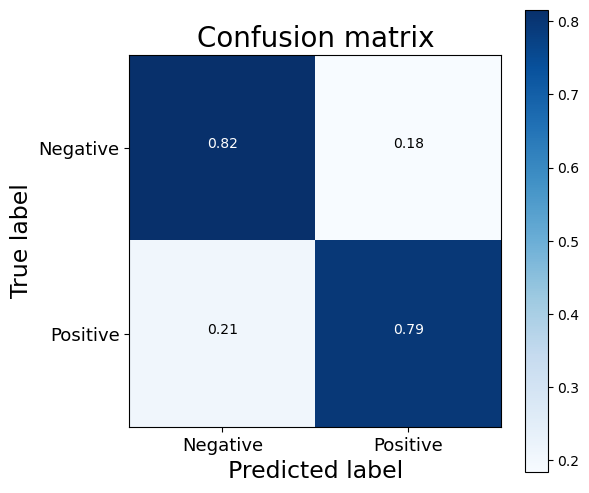

In [30]:
cnf_matrix = np.asarray(cm_)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion matrix")
plt.show()

# ResNet

Here I create a residual network, which is much more complicated than the basic CNN.

In [31]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, input):
        residual = input
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = self.relu(x)

        return x

In [32]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.res1 = ResidualBlock(16, 16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.res2 = ResidualBlock(32, 32) # Max pool and res block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.res3 = ResidualBlock(64, 64) # Max pool and res block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.res4 = ResidualBlock(128, 128)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.mp = nn.MaxPool2d(2)
        self.sig = nn.Sigmoid()

    def forward(self, input):
        x = input.transpose(1, 3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.res1(x)
        x = self.mp(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.res2(x)
        x = self.mp(x)
        x = self.res2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.res3(x)
        x = self.mp(x)
        x = self.res3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.res4(x)
        x = self.mp(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x

In [33]:
model = ResNet().to(device)

In [34]:
print(sum(p.numel() for p in model.parameters())/1e6, 'Million parameters')

1.539921 Million parameters


In [35]:
lr=1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [36]:
def train(epochs):
    for epoch in range(epochs):
        for i, (batch, labels) in enumerate(train_dataloader):
            batch, labels = batch.to(device), labels.to(device)
            labels = labels.float()
            batch = batch.float()
            
            model.zero_grad()
            
            output = model(batch)[:, 0]
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print(f'step: {i} Loss: {loss}')

In [37]:
train(1)

step: 0 Loss: 0.7446333765983582
step: 500 Loss: 0.23526789247989655
step: 1000 Loss: 0.44705185294151306
step: 1500 Loss: 0.21302218735218048


# ResNet Results

The ResNet performed much better than the basic CNN with an accuracy of 87% on the validation set. This is the model I will be submitting to the leaderboards.

In [38]:
print_accuracy(val_dataloader)

/tmp/ipykernel_28/3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.871023450281767


In [39]:
cm_ = cm(val_dataloader)

/tmp/ipykernel_28/1465458185.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


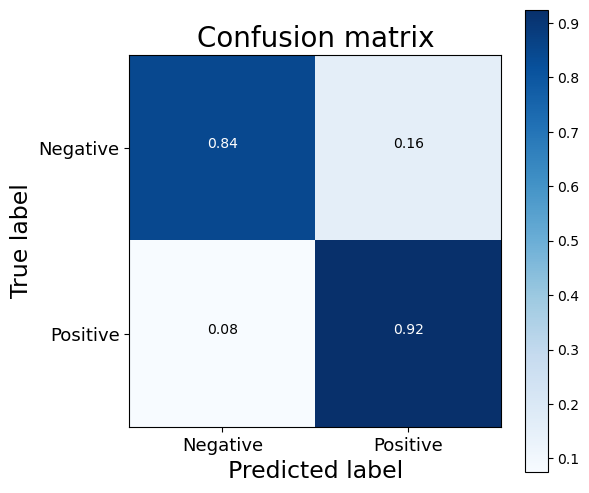

In [40]:
cnf_matrix = np.asarray(cm_)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion matrix")
plt.show()

# Conclusion

This last bit of code is just creating a submission for the leaderboards. This notebook achieved a score of 0.8141. I think to improve this score the ResNet could simply be trained longer, I dont think it has converged yet. I only trained it for 1 epoch as training was slow.

In [ ]:
test_imgs = os.listdir(test_dir)

In [ ]:
class CustomDatasetTest(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = torch.Tensor(np.asarray(Image.open(test_dir + '/' + self.examples[idx])))
        
        return example

In [ ]:
test_dataset = CustomDatasetTest(test_imgs)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        batch = batch.float()

        output = model(batch)[:, 0]
        output = output.detach().cpu().numpy()
        
        for out in output:
            predictions.append(out)

In [ ]:
for i in range(len(predictions)):
    predictions[i] = 0 if predictions[i] < 0.5 else 1

In [ ]:
for i in range(len(test_imgs)):
    test_imgs[i] = test_imgs[i].split('.')[0]

In [ ]:
submission_df = pd.DataFrame({'id': test_imgs})

In [ ]:
predictions_df = pd.DataFrame({'label': predictions})

In [ ]:
submission = pd.concat([submission_df, predictions_df], axis=1)

In [ ]:
submission.to_csv('submission.csv', index=False)